In [2]:
import json
import numpy as np
import pyvista as pv
from pymeshfix import MeshFix
import cityjson

In [3]:
float_formatter = "{:.3f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

models = {
    "DenHaag": "",
    "Helsinki": "/Users/liberostelios/Dropbox/CityJSON/Helsinki/CityGML_BUILDINGS_LOD2_NOTEXTURES_672496x2.json",
    "Vienna": "/Users/liberostelios/Dropbox/CityJSON/Vienna/Vienna_102081.json",
    "Montreal": "/Users/liberostelios/Downloads/random10_1.json"
}

filename = models["Montreal"]

with open(filename) as file:
    cm = json.load(file)

if "transform" in cm:
    s = cm["transform"]["scale"]
    t = cm["transform"]["translate"]
    verts = [[v[0] * s[0] + t[0], v[1] * s[1] + t[1], v[2] * s[2] + t[2]]
            for v in cm["vertices"]]
else:
    verts = cm["vertices"]

# mesh points
vertices = np.array(verts)

In [4]:
# obj = "GUID_816CA7F9-6357-447D-96E3-C74C5E47AABF_2" # Den Haag
obj = list(cm["CityObjects"].keys())[0]
# obj = "UUID_LOD2_210138-f86f7351-7cad-4e8f-826f_2" # Vienna

building = cm["CityObjects"][obj]

In [5]:
dataset = cityjson.to_polydata(building["geometry"][0], vertices)
dataset = dataset.clean()
dataset.plot(show_edges=True)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [6]:
trimesh = cityjson.to_triangulated_polydata(building["geometry"][0], vertices).clean()
trimesh.plot()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [7]:
trimesh.clean().extract_feature_edges().plot()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [8]:
p = pv.Plotter()

p.add_mesh(trimesh)
p.add_mesh(trimesh.extract_feature_edges(), color='black')

p.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [9]:
edges = trimesh.extract_feature_edges(boundary_edges=True,
                           feature_edges=False,
                           manifold_edges=False)

p = pv.Plotter()

p.add_mesh(trimesh, opacity=0.5)
if trimesh.n_open_edges:
    p.add_mesh(edges, color='red', line_width=10)

p.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [10]:
clean = trimesh.clean()
voxel = pv.voxelize(clean, density=clean.length/100, check_surface=False)
voxel.plot(show_edges=True, text=f"[{obj}] Voxelized")

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [11]:
print(f"Voxel: {voxel.volume}")
print(f"Actual: {trimesh.volume}")

Voxel: 1431.825477038297
Actual: 1314.5061478069588


In [12]:
p = pv.Plotter()

p.add_mesh(voxel, opacity=0.2, show_edges=True, color='yellow')
p.add_mesh(voxel.cell_centers(), color='black')
p.add_mesh(clean, color='grey')
p.add_mesh(pv.PolyData(np.mean(voxel.cell_centers().points, axis=0)), color='white')

p.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [13]:
clean = trimesh.clean()
# clean.points -= np.mean(clean.points, axis=0)
voxel = pv.voxelize(clean, density=clean.length/100)
voxel.n_cells

87160

In [14]:
from helpers.minimumBoundingBox import MinimumBoundingBox

In [15]:
obb_2d = MinimumBoundingBox([(p[0], p[1]) for p in dataset.clean().points])
obb_2d.area

79.87442991259086

In [16]:
obb_2d.area

79.87442991259086

In [17]:
ground_z = np.min(dataset.clean().points[:, 2])
height = np.max(dataset.clean().points[:, 2]) - ground_z
box = np.array([[p[0], p[1], ground_z] for p in list(obb_2d.corner_points)])

In [18]:
obb = pv.PolyData(box).delaunay_2d()
pts = obb.points

t = np.mean(pts, axis=0)

obb.points = obb.points - t
obb = obb.extrude([0.0, 0.0, height])
obb.points = obb.points + t

In [19]:
p = pv.Plotter()

p.add_mesh(obb, opacity=0.3)
p.add_mesh(trimesh)

p.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [20]:
dataset.clean().triangulate().volume

1314.5061479872948

In [21]:
m = MeshFix(obb.clean().triangulate())
m.repair()
fixed_obb = m.mesh

In [22]:
fixed_obb.volume

1409.3043596692721

In [23]:
pv.PolyData(box).delaunay_2d().area * height

1409.3044413469472

In [24]:
obb.faces

array([3, 3, 2, 1, 3, 7, 6, 5, 3, 3, 1, 0, 3, 7, 5, 4])

In [25]:
from pyobb.obb import OBB

obb_full_3d = OBB.build_from_points(dataset.clean().points)
obb_full_3d.points

[array([300661.362, 5041288.754, 16.386]),
 array([300658.237, 5041282.894, 16.570]),
 array([300658.691, 5041283.209, 34.417]),
 array([300661.816, 5041289.069, 34.234]),
 array([300646.020, 5041289.416, 16.765]),
 array([300649.145, 5041295.276, 16.582]),
 array([300649.599, 5041295.591, 34.430]),
 array([300646.474, 5041289.731, 34.613])]

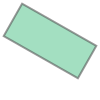

In [26]:
from cityjson import to_shapely

obb_2d = to_shapely(building["geometry"][0], vertices).minimum_rotated_rectangle
obb_2d

In [27]:
from geometry import extrude

ground_z = np.min(dataset.clean().points[:, 2])
roof_z = np.max(dataset.clean().points[:, 2])
obb = extrude(obb_2d, ground_z, roof_z)

In [28]:
p = pv.Plotter()

p.add_mesh(obb, show_edges=True, opacity=0.3)
p.add_mesh(trimesh)

p.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [29]:
m = MeshFix(obb.clean().triangulate())
m.repair()
fixed_obb = m.mesh

print(f"Volume: {trimesh.volume}")
print(f"OBB: {obb.volume}")

p = pv.Plotter()

p.add_mesh(obb.clean(), show_edges=True, opacity=0.3)
p.add_mesh(trimesh)

p.show()

Volume: 1314.5061478069588
OBB: 1409.3043411738627


ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [30]:
obb.triangulate().clean()

PolyData,Information
N Cells,12
N Points,8
X Bounds,"-6.455e+00, 8.224e+00"
Y Bounds,"-7.089e+00, 4.726e+00"
Z Bounds,"0.000e+00, 1.764e+01"
N Arrays,0


In [31]:
fixed_obb

PolyData,Information
N Cells,12
N Points,8
X Bounds,"-6.455e+00, 8.224e+00"
Y Bounds,"-7.089e+00, 4.726e+00"
Z Bounds,"0.000e+00, 1.764e+01"
N Arrays,0


In [75]:
from shapely.geometry import Point, MultiPoint, Polygon
import math
from tqdm.notebook import trange, tqdm

def create_grid_2d(shape, density):
    """Return the grid for a given polygon"""
    
    x_min, y_min, x_max, y_max = shape.bounds
    x = np.arange(x_min, x_max, density)
    y = np.arange(y_min, y_max, density)
    x, y = np.meshgrid(x, y)
    
    x = np.hstack(x)
    y = np.hstack(y)
    
    return [(x[i], y[i]) for i in range(len(x))]

def create_grid_3d(mesh, density, check_surface=False):
    """Returns the grid for a given mesh"""
    voxel = pv.voxelize(mesh, density=density, check_surface=check_surface)
    
    return voxel.cell_centers().points

def distance(x, y):
    """Returns the euclidean distance between two points"""
    
    return math.sqrt(sum([math.pow(x[c] - y[c], 2) for c in range(len(x))]))

def cohesion_2d(shape, grid=None, density=1):
    """Returns the cohesion index in 2D for a given polygon"""
    
    if grid is None:
        grid = create_grid(shape, density)
    
    if isinstance(grid, list):
        grid = MultiPoint(grid).intersection(shape)
    
    d = 0
    for pi in tqdm(grid.geoms):
        for pj in grid.geoms:
            if pi == pj:
                continue
            
            d += pi.distance(pj)

    n = len(grid.geoms)
    return 0.9054 * math.sqrt(shape.area / math.pi) / (1 / (n * (n - 1)) * d)

def cohesion_3d(mesh, density=1, check_surface=False):
    """Returns the cohesion index in 3D for a given mesh"""
    
    voxel = pv.voxelize(mesh, density=density, check_surface=check_surface)
    grid = voxel.cell_centers().points
    
    d = 0
    for pi in tqdm(grid):
        for pj in grid:
            d += distance(pi, pj)
    
    # TODO: Calculate the actual formula here
    return d

def proximity_2d(shape, density=1, grid=None):
    """Returns the proximity index in 2D for a given polygon"""
    
    if grid is None:
        grid = create_grid(shape, density)
    
    if isinstance(grid, list):
        grid = MultiPoint(grid).intersection(shape)
    
    centroid = shape.centroid
    
    return 2 / 3 * math.sqrt(shape.area / math.pi) / np.mean([centroid.distance(p) for p in grid])

def proximity_3d(mesh, grid=None, density=1, check_surface=False):
    """Returns the cohesion index in 3D for a given mesh"""
    
    if grid is None:
        voxel = pv.voxelize(mesh, density=density, check_surface=check_surface)
        grid = voxel.cell_centers().points
    
    centroid = np.mean(grid, axis=0)
    
    # TODO: Calculate the actual formula here
    return np.mean([distance(centroid, p) for p in grid])

def equal_volume_sphere(mesh, position=(0, 0, 0)):
    """Returns the sphere that has the same volume as the given mesh"""
    
    r = math.pow(3 * mesh.volume / (4 * math.pi), 1/3)
    
    return pv.Sphere(radius=r, center=position)

def exchange_2d(shape):
    """Returns the exchange index in 2D for a given polygon"""
    
    r = math.sqrt(shape.area / math.pi)
    
    eac = shape.centroid.buffer(r)
    
    return shape.intersection(eac).area / shape.area

def exchange_3d(mesh, evs=None, engine="igl"):
    """Returns the exhange index in 3D for a given mesh"""
    
    if evs is None:
        voxel = pv.voxelize(clean, density=0.25)
        grid = voxel.cell_centers().points

        centroid = np.mean(grid, axis=0)
        evs = equal_volume_sphere(mesh, centroid)
    
    pm_mesh = to_pymesh(mesh)
    pm_evs = to_pymesh(evs)
    
    inter = pymesh.boolean(pm_mesh, pm_evs, operation="intersection", engine=engine)
    
    return inter.volume / mesh.volume
    
# cohesion_2d(Point(0,0).buffer(1.0), density=0.1)
# cohesion_3d(clean)
# proximity_2d(Point(0,0).buffer(1.0), 0.25)
# voxel = pv.voxelize(clean, density=0.25)
# grid = voxel.cell_centers().points

# centroid = np.mean(grid, axis=0)

exchange_3d(clean, evs)
# exchange_2d(Point(0, 0).buffer(25))

# proximity_3d(evs, density=0.25) / proximity_3d(clean, density=0.25)

0.5840967484587085

In [33]:
evs = equal_volume_sphere(clean, centroid)

In [56]:
import pymesh

def to_pymesh(mesh):
    """Returns a pymesh from a pyvista PolyData"""
    v = mesh.points
    f = mesh.faces.reshape(-1, 4)[:, 1:]

    return pymesh.form_mesh(v, f)

def to_pyvista(mesh):
    """Return a PolyData from a pymesh"""
    v = mesh.vertices
    f = mesh.faces
    
    f = np.hstack([[len(f)] + list(f) for f in mesh.faces])
    
    return pv.PolyData(v, f, len(mesh.faces))

clean_pm = to_pymesh(clean)
evs_pm = to_pymesh(evs)

In [47]:
inter = pymesh.boolean(clean_pm, evs_pm, operation="intersection", engine="igl")

array([[300647.172, 5041289.747, 25.088],
       [300647.172, 5041289.747, 25.455],
       [300647.172, 5041289.747, 25.824],
       ...,
       [300660.596, 5041288.615, 25.088],
       [300660.596, 5041288.615, 25.371],
       [300660.596, 5041288.615, 25.824]])

In [67]:
p = pv.Plotter()

p.add_mesh(evs, opacity=0.2, color='yellow')
p.add_mesh(to_pyvista(inter), opacity=0.5, color='blue')

p.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)